# Effect of Stochasticity and Macroscopic stepsizes in Diagonal Linear Networks(DLN)

Stochastic Gradient Descent is one of the most widely used optimization algorithms for Deep Learning. Empirical evidence has shown that the solution produced by this approach benefits from an implicit bias. In the context of Diagonal Linear Networks, the effect of stochasticity and stepsize on this implicit bias has recently been demonstrated. Specifically, Stochastic Gradient Descent benefits from a larger stepsize, while Gradient Descent suffers from it. The objective of this notebook is to empirically observe this effect.

## Setting

We want to compute the output $y \in \mathbb{R}^n$ from the input $X \in (\mathbb{R}^d)^n$, where the input dimension $d$ is much larger than the number of samples $n$. Then, there are infinite interpolators, i.e., $\beta^\star$ such that $y_i = \langle \beta^\star, x_i \rangle$. We denote $$\mathcal{S}:=\left\{ \beta^\star \in \mathbb{R}^d \text{ st } \langle\beta^\star, x_i\rangle =y_i, \forall i\in[n]\right\}$$
the set of interpolators.

### Diagonal Linear Networks(DLN)
We consider the parametrisation $\langle \beta, x\rangle=\langle u \odot v, x\rangle$, where $w=(u,v)\in \mathbb{R}^{2d}$ are the weights. It can be seen as a simple neural network with activation function $\sigma$ the identity: $x\to \langle u \odot v, x\rangle= \langle u, \sigma(\mathrm{diag}(v)x)\rangle$.

### Loss function
For a minibatch $\mathcal{B}_k\subset [n]$ of size $b$, we define the loss function on the batch as $$F_{\mathcal{B}}(w):=\mathcal{L}_\mathcal{B}(u\odot v)=\frac{1}{2b}\underset{i\in\mathcal{B}}{\sum}(y_i-\langle u\odot v, x_i\rangle)^2.$$
### (S)GD
We will obtain the final weights by iterating $w_0=(u_0, v_0)$, $w_{k+1}=w_k-\gamma_k\nabla F_{\mathcal{B}_k}(w_k)$, where $\gamma_k$ are the stepsizes and the mini-batches $\mathcal{B}_k\subset[n]$ of size $b$ are sampled uniformly and independently. In particular, GD is for $b=n$.
 We will take $u_0=\sqrt{2}\alpha\mathbf{1}$ and $v_0=\mathbf{0}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

We have toy datasets that allow us to construct a simulation plan. We modulate the sparsity of $\beta$ by changing the value of $s$. We set $d$ = 30 and $n$ = 20 so that $d > n$.
Both $X$ and the support of $\beta$ are sampled from a Gaussian distribution.



In [2]:
class ToyCenteredLinear():
    """ Generate a toy dataset for linear regression with centered features and a s sparse $\beta$ vector.
    input:
        n: number of samples
        p: number of features
        s: number of non-zero coefficients
        random_state: random seed
    """
    
    def __init__(self, n, p, s, random_state=30):
        self.n = n
        self.p = p
        self.s = s
        self.random_state = random_state

    def generate(self):
        """ Generate a toy dataset for linear regression with centered features and a s sparse $\beta$ vector.

        output:
            X: n by p feature matrix
            y: n by 1 response vector
            beta: p by 1 coefficient vector
        """
        np.random.seed(self.random_state)
        X = np.random.normal(size=(self.n, self.p))
        beta = np.zeros(self.p)
        beta[:self.s] = np.random.normal(size=self.s, scale=10)
        y = X @ beta.T
        return X, y, beta
    


We also have a Net class in which we implemented our model. We choose SGD or GD by setting the batch_size parameter to 1 or n respectively.

In [3]:
class Net():
    """ A simple neural network with one hidden layer.
    input:
        n: number of samples
        d: number of features
        s: number of hidden units
        alpha: coefficient for the initialization of the weights
        gamma: learning rate
        batch_size: size of the mini-batch
        random_state: random seed
    """

    def __init__(self, n, d, s, alpha, gamma, batch_size, random_state=30):
        self.n = n
        self.d = d
        self.s = s
        self.alpha = alpha
        self.lr = gamma
        self.random_state = random_state
        self.u = np.ones(self.d)* self.alpha* np.sqrt(2)
        self.v = np.zeros(self.d)
        self.batch_size = batch_size
        self.gain = np.zeros(self.d)

    def q(self,x):
        """ Compute the value of the quadratic function q(x) = -0.5*np.log((1- x**2)**2)
        input:
            x: matrix or vector
        output:
            float: value of the quadratic function
        """
        return -0.5*np.log((1- x**2)**2)

    def loss(self, X, y):
        """ Compute the loss of the current model on the given data.
        input:
            X: feature matrix
            y: response vector
        output:
            float: loss value
        """
        return 0.5*np.mean((y - X@(self.u*self.v))**2)
    
    def gradient_loss(self, X, y):
        """ Compute the gradient of the loss of the current model on the given data.
        input:
            X: feature matrix
            y: response vector
        output:
            vector: gradient of the loss
        """
        return 1/X.shape[0]*((y-X@(self.u*self.v)).T@X)
     

    def forward(self, X):
        """
        Compute the prediction of the current model on the given data.
        input:
            X: feature matrix
        output:
            vector: prediction
        """
        return X@(self.u*self.v)
    
    def get_beta(self):
        """ Return the current coefficient vector.
        output:
            vector: coefficient vector
        """
        return self.u*self.v

    def optim(self, X, y):
        """ Update the coefficient vector, and the gain using the given data.
        input:
            X: feature matrix
            y: response vector
        """
        ind = np.random.choice(self.n, self.batch_size, replace=False)
        X_prime = X[ind]
        y_prime = y[ind]

        self.gain+=self.q(self.lr*self.gradient_loss(X_prime, y_prime))
        
        grad_u = np.mean([(np.dot(np.multiply(self.u, self.v), X_prime[j]) - y_prime[j])*np.multiply(self.v, X_prime[j]) for j in range(self.batch_size)], axis=0)
        grad_v = np.mean([(np.dot(np.multiply(self.u, self.v), X_prime[j]) - y_prime[j])*np.multiply(self.u, X_prime[j]) for j in range(self.batch_size)], axis=0)

        self.u = self.u - self.lr * grad_u
        self.v = self.v - self.lr * grad_v
        

        


We generate a toy dataset for which we split into train/test. This allows us to train our models and reproduce the graphs from the article.

In [4]:
n = 20
ntest=1000
d = 30
s = 3
alpha = 0.1
epsilon = 1e-5

max_iter=100000

X, y, beta = ToyCenteredLinear(n+ntest, d, s).generate()

X_train=X[:n,:]
y_train=y[:n]
X_test=X[n:,]
y_test=y[n:]


## Main Result: 
The main result is that if the (S)GD converges, then its outcome is the solution of a regularisation problem:
$$\beta_{\infty}^\star= \underset{\beta^\star\in\mathcal{S}}{\mathrm{argmin}}\mathcal{D}_{\psi_{\alpha_\infty}}\left(\beta^\star, \widetilde{\beta}_0\right)\approx\underset{\beta^\star\in\mathcal{S}}{\mathrm{argmin}}\psi_{\alpha_\infty}(\beta^\star),$$
where $\mathcal{D}_{\psi_{\alpha_\infty}}$ is the Bregman Divergence of the hyperentropy $\psi_{\alpha_\infty}$. For a comprehensive explanation, please refer to the report associated with this notebook. Here, we will only utilize the approximation provided by  $\psi_{\alpha_\infty}(\beta)\sim\mathrm{ln}\left(\frac{1}{\alpha}\right)\|\beta\|_1+\sum_{i=1}^d\mathrm{Gain}_\gamma(i)|\beta_i|$, where $\mathrm{Gain}_\gamma$ is a vector depending on the stepsize and the trajectory of the algorithm. 


First, it is demonstrated that as the stepsize increases, the $\mathrm{Gain}_\gamma$ also increases, becoming arbitrarily large in the Edge of Stability regime, which is the narrow window before the divergence of the algorithm.

From this expression, we also observe that if the $\mathrm{Gain}_\gamma$ is not uniform, then the algorithm will solve a weighted $\ell_1$-penalization. As will be seen later, for the GD, this is the case, having a larger weight on the support, which hinders its recovery and explains the poor generalization of the algorithm. On the other hand, for the SGD, this vector is homogeneous, providing an almost uniform $\ell_1$ penalization, which allows for the recovery of the support parameters.


In [5]:
learning_rates_SGD = np.linspace(1e-2, 0.4, 1000)
learning_rates_GD = np.linspace(1e-2, 0.4, 1000)

converged_learning_rates_GD=[]
converged_learning_rates_SGD=[]

loss_SGD = []
loss_GD = []

gain_SGD = []
gain_GD = []

beta_GD=[]
beta_SGD=[]


for lr in learning_rates_SGD:
    it=0
    net = Net(n, d, s, alpha, lr, 1)
    while net.loss(X_train, y_train) > epsilon and (it< max_iter):
        net.optim(X_train, y_train)
        it+=1
    if np.isnan(net.loss(X_train, y_train)) or it==max_iter:
        break
    loss_SGD.append(net.loss(X_test, y_test))
    converged_learning_rates_SGD.append(lr)
    gain_SGD.append(np.sqrt(np.sum(net.gain**2)))
    beta_SGD.append(np.sqrt(np.sum(beta-net.get_beta())**2))

for lr in learning_rates_GD:
    net = Net(n, d, s, alpha, lr, n)
    it=0
    while net.loss(X_train, y_train) > epsilon and (it< max_iter):
        net.optim(X_train, y_train)
        it+=1
    if np.isnan(net.loss(X_train,y_train)) or it == max_iter:#it did not converge
        break
    converged_learning_rates_GD.append(lr)
    loss_GD.append(net.loss(X_test, y_test))
    beta_GD.append(np.sqrt(np.sum(beta-net.get_beta())**2))
    gain_GD.append(np.sqrt(np.sum(net.gain**2)))
    



C:\Users\angel\AppData\Local\Temp\ipykernel_16616\594322722.py:32: RuntimeWarning: overflow encountered in square
  return -0.5*np.log((1- x**2)**2)
C:\Users\angel\AppData\Local\Temp\ipykernel_16616\594322722.py:42: RuntimeWarning: overflow encountered in square
  return 0.5*np.mean((y - X@(self.u*self.v))**2)
C:\Users\angel\AppData\Local\Temp\ipykernel_16616\594322722.py:84: RuntimeWarning: overflow encountered in multiply
  grad_u = np.mean([(np.dot(np.multiply(self.u, self.v), X_prime[j]) - y_prime[j])*np.multiply(self.v, X_prime[j]) for j in range(self.batch_size)], axis=0)
C:\Users\angel\AppData\Local\Temp\ipykernel_16616\594322722.py:85: RuntimeWarning: overflow encountered in multiply
  grad_v = np.mean([(np.dot(np.multiply(self.u, self.v), X_prime[j]) - y_prime[j])*np.multiply(self.u, X_prime[j]) for j in range(self.batch_size)], axis=0)
C:\Users\angel\AppData\Local\Temp\ipykernel_16616\594322722.py:42: RuntimeWarning: invalid value encountered in matmul
  return 0.5*np.mean((y

 We can notice that as the step size increases, SGD provides a better solution, while GD gives a worse solution.

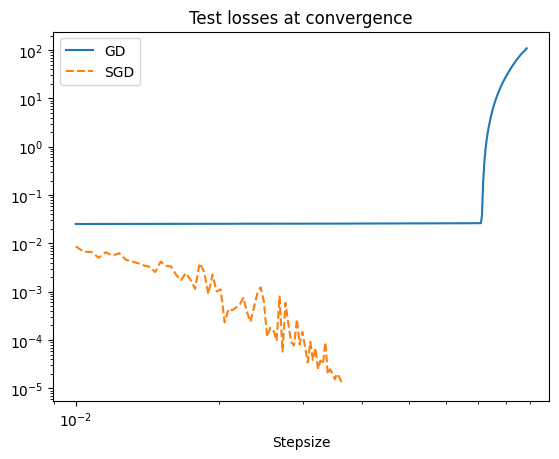

In [6]:
plt.loglog(converged_learning_rates_GD, loss_GD, label='GD')
plt.loglog(converged_learning_rates_SGD, loss_SGD, label='SGD', linestyle='--')
plt.xlabel("Stepsize")
plt.legend()
plt.title("Test losses at convergence")
plt.savefig('Report/test-losses.pdf', format='pdf')
plt.show()

We compare the recovered parameters with the underlying true ones:

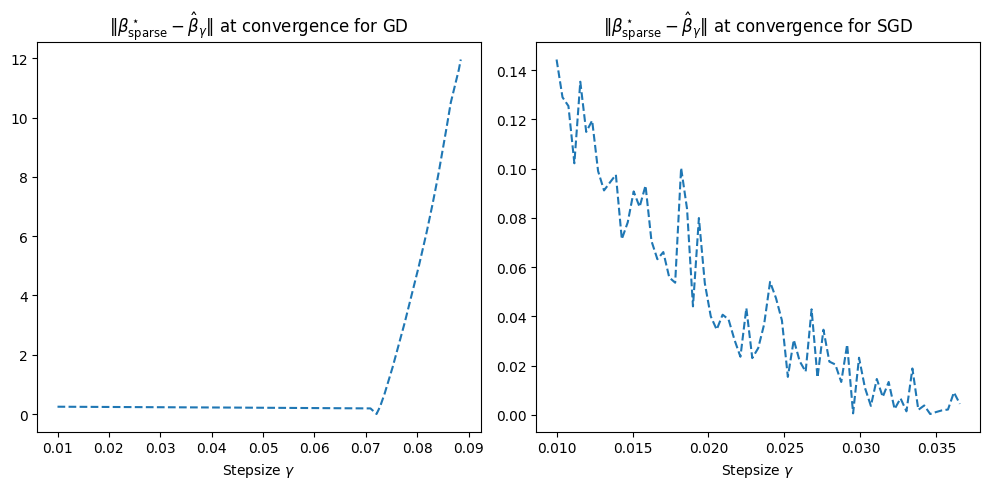

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(converged_learning_rates_GD, beta_GD, label='GD', linestyle='--')
axs[0].set_xlabel("Stepsize $\gamma$")
axs[0].set_title(r"$\|\beta_\mathrm{sparse}^\star - \hat{\beta}_{\gamma}\|$ at convergence for GD")

axs[1].plot(converged_learning_rates_SGD, beta_SGD, label='SGD', linestyle='--')
axs[1].set_xlabel("Stepsize $\gamma$")
axs[1].set_title(r"$\|\beta_\mathrm{sparse}^\star - \hat{\beta}_{\gamma}\|$ at convergence for SGD")


plt.tight_layout()
plt.savefig('Report/betas-losses.pdf', format='pdf')
plt.show()

### Scale of $\mathrm{Gain}_\gamma$

We observe that the $\mathrm{Gain}_\gamma$ gets arbitrarily large:

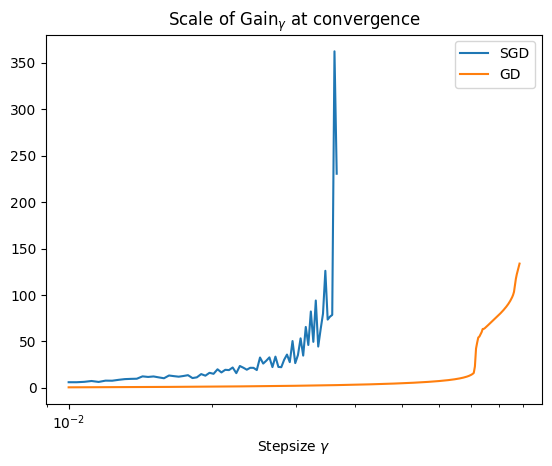

In [8]:
plt.semilogx(converged_learning_rates_SGD, gain_SGD, label='SGD')
plt.semilogx(converged_learning_rates_GD, gain_GD, label='GD')
plt.xlabel("Stepsize $\gamma$")
plt.title("Scale of $\mathrm{Gain}_\gamma$ at convergence")
plt.legend()   
plt.savefig('Report/scale_gain.pdf', format='pdf')

### Shape of $\mathrm{Gain}_\gamma$
In the sequel, we will empirically demonstrate that the shape of $\mathrm{Gain}_\gamma$ is what distinguishes the generalization properties of GD and SGD. Specifically, at the Edge of Stability, the shape of $\mathrm{Gain}_\gamma$ for GD is heterogeneous, being bigger on the support coordinates. Conversely, for SGD, the shape is homogeneous. To illustrate this, we start by computing the maximum stepsize for which the algorithms converge:

In [9]:
n_simul=500 #shape_gain
X, y, beta = ToyCenteredLinear(n*n_simul, d, s).generate()

X_converged = X[:n,:]
y_converged = y[:n]

learning_rates_GD = np.linspace(1e-2, 0.2, 500)

max_converged_learning_rates_GD=[]

max_iter= 50000
for lr in learning_rates_GD:
    net = Net(n, d, s, alpha, lr, n)
    it=0
    while net.loss(X_converged, y_converged) > epsilon and (it< max_iter):
        net.optim(X_converged, y_converged)
        it+=1
    if it==max_iter or np.isnan(net.loss(X_converged, y_converged)):#it did not converge
        break
    max_converged_learning_rates_GD.append(lr)


max_iter=80000
learning_rates_SGD = np.linspace(1e-2, 0.15, 100)
max_converged_learning_rates_SGD = []

for lr in learning_rates_SGD:
    it=0
    net = Net(n, d, s, alpha, lr, 1)
    while net.loss(X_converged, y_converged) > epsilon and (it< max_iter):
        net.optim(X_converged, y_converged)
        it+=1
    if it == max_iter or np.isnan(net.loss(X_converged, y_converged)):
        break
    max_converged_learning_rates_SGD.append(lr)



C:\Users\angel\AppData\Local\Temp\ipykernel_16616\594322722.py:32: RuntimeWarning: overflow encountered in square
  return -0.5*np.log((1- x**2)**2)
C:\Users\angel\AppData\Local\Temp\ipykernel_16616\594322722.py:42: RuntimeWarning: overflow encountered in square
  return 0.5*np.mean((y - X@(self.u*self.v))**2)
C:\Users\angel\AppData\Local\Temp\ipykernel_16616\594322722.py:84: RuntimeWarning: overflow encountered in multiply
  grad_u = np.mean([(np.dot(np.multiply(self.u, self.v), X_prime[j]) - y_prime[j])*np.multiply(self.v, X_prime[j]) for j in range(self.batch_size)], axis=0)
C:\Users\angel\AppData\Local\Temp\ipykernel_16616\594322722.py:85: RuntimeWarning: overflow encountered in multiply
  grad_v = np.mean([(np.dot(np.multiply(self.u, self.v), X_prime[j]) - y_prime[j])*np.multiply(self.u, X_prime[j]) for j in range(self.batch_size)], axis=0)
C:\Users\angel\AppData\Local\Temp\ipykernel_16616\594322722.py:42: RuntimeWarning: invalid value encountered in matmul
  return 0.5*np.mean((y

Fixing the stepsize at the maximum value for which the algorithm converged, we run the algorithm multiple times and recover the $\mathrm{Gain}_\gamma$ for each experiment.

In [10]:
# Plotting the shape of Gain for GD
max_iter = 50000
gains_GD = np.zeros((n_simul, d))
ind_not_cv_GD = []

for i in range(n_simul):
    it = 0
    net = Net(n, d, s, alpha, max_converged_learning_rates_GD[-1], n)
    X_train = X[i*n:(i+1)*n]
    y_train = y[i*n:(i+1)*n]
    
    while net.loss(X_train, y_train) > epsilon and (it < max_iter):
        net.optim(X_train, y_train)
        it += 1
    
    if it != max_iter:  # it converged
        gains_GD[i] = net.gain
    else:
        ind_not_cv_GD.append(i)



# Plotting the shape of Gain for SGD
max_iter = 80000
gains_SGD = np.zeros((n_simul, d))
ind_not_cv_SGD = []

for i in range(n_simul):
    it = 0
    net = Net(n, d, s, alpha, max_converged_learning_rates_SGD[-1], 1)
    X_train = X[i*n:(i+1)*n]
    y_train = y[i*n:(i+1)*n]
    
    while net.loss(X_train, y_train) > epsilon and (it < max_iter):
        net.optim(X_train, y_train)
        it += 1
    
    
    if it != max_iter:  # it converged
        gains_SGD[i] = net.gain
    else:
        ind_not_cv_SGD.append(i)



C:\Users\angel\AppData\Local\Temp\ipykernel_16616\594322722.py:32: RuntimeWarning: overflow encountered in square
  return -0.5*np.log((1- x**2)**2)
C:\Users\angel\AppData\Local\Temp\ipykernel_16616\594322722.py:42: RuntimeWarning: overflow encountered in multiply
  return 0.5*np.mean((y - X@(self.u*self.v))**2)
C:\Users\angel\AppData\Local\Temp\ipykernel_16616\594322722.py:42: RuntimeWarning: invalid value encountered in matmul
  return 0.5*np.mean((y - X@(self.u*self.v))**2)
C:\Users\angel\AppData\Local\Temp\ipykernel_16616\594322722.py:42: RuntimeWarning: overflow encountered in square
  return 0.5*np.mean((y - X@(self.u*self.v))**2)
C:\Users\angel\AppData\Local\Temp\ipykernel_16616\594322722.py:84: RuntimeWarning: overflow encountered in multiply
  grad_u = np.mean([(np.dot(np.multiply(self.u, self.v), X_prime[j]) - y_prime[j])*np.multiply(self.v, X_prime[j]) for j in range(self.batch_size)], axis=0)
C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2k

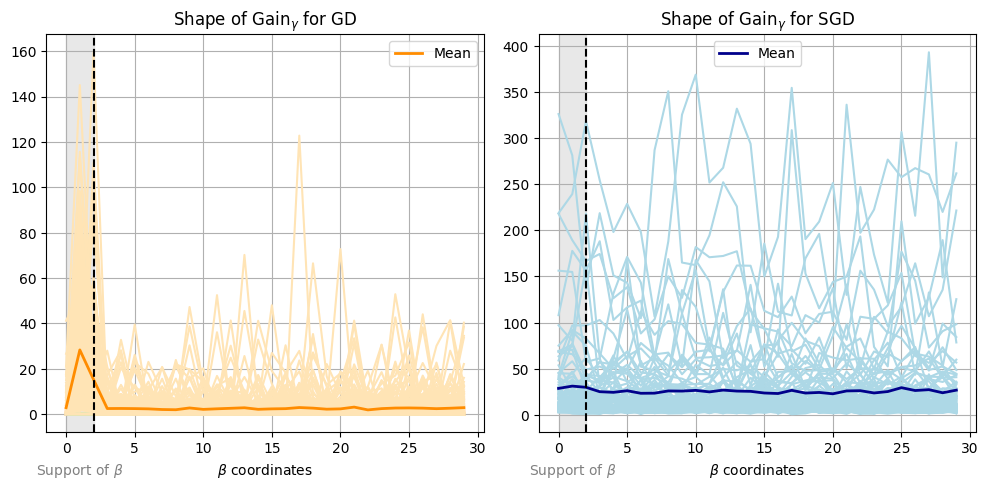

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i in range(n_simul):
    ax[0].plot(range(d), gains_GD[i], color="moccasin")

gains2_GD = np.delete(gains_GD, ind_not_cv_GD, axis=0)
gains_filt_GD = gains2_GD[~np.isinf(gains2_GD).any(axis=1)]
mn_GD = np.mean(gains_filt_GD, axis=0)
ax[0].plot(range(d), mn_GD, color="darkorange", linewidth=2, label='Mean')
ax[0].axvline(x=s-1, color="black", linestyle="--")
ax[0].set_title(r'Shape of $\mathrm{Gain}_\gamma$ for GD')
ax[0].set_xlabel(r'$\beta$ coordinates')
ax[0].grid(True)

support_beta = (0,s-1)
ax[0].axvspan(support_beta[0], support_beta[1], color='lightgrey', alpha=0.5)
ax[0].text((support_beta[0] + support_beta[1]) / 2, -25, r'Support of $\beta$',
         horizontalalignment='center', verticalalignment='center', color = 'grey')
ax[0].legend()

for i in range(n_simul):
    ax[1].plot(range(d), gains_SGD[i], color="lightblue")

gains2_SGD = np.delete(gains_SGD, ind_not_cv_SGD, axis=0)
gains_filt_SGD = gains2_SGD[~np.isinf(gains2_SGD).any(axis=1)]
mn_SGD = np.mean(gains_filt_SGD, axis=0)
ax[1].plot(range(d), mn_SGD, color="darkblue", linewidth=2, label='Mean')
ax[1].set_title('Shape of $\mathrm{Gain}_\gamma$ for SGD')
ax[1].set_xlabel(r'$\beta$ coordinates')
ax[1].grid(True)
ax[1].axvline(x=s-1, color="black", linestyle="--")
ax[1].axvspan(support_beta[0], support_beta[1], color='lightgrey', alpha=0.5)
ax[1].text((support_beta[0] + support_beta[1]) / 2, -60, r'Support of $\beta$',
         horizontalalignment='center', verticalalignment='center', color = 'grey')

ax[1].legend()

plt.legend()
plt.tight_layout()
plt.savefig('Report/shape_gain.pdf', format='pdf')

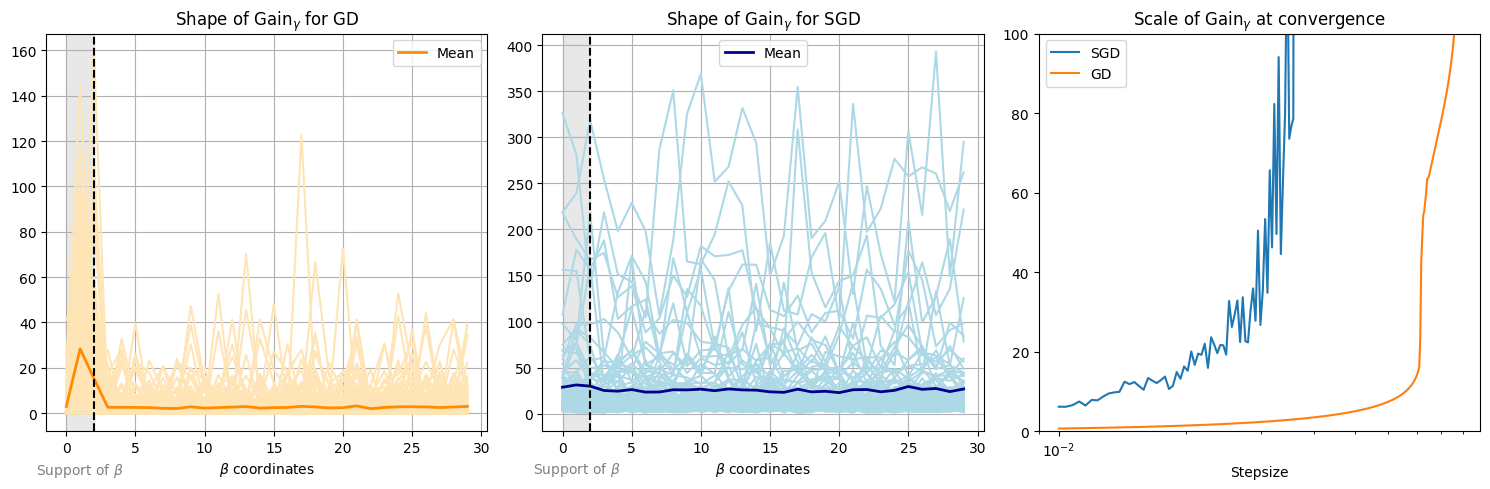

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i in range(n_simul):
    ax[0].plot(range(d), gains_GD[i], color="moccasin")

gains2_GD = np.delete(gains_GD, ind_not_cv_GD, axis=0)
gains_filt_GD = gains2_GD[~np.isinf(gains2_GD).any(axis=1)]
mn_GD = np.mean(gains_filt_GD, axis=0)
ax[0].plot(range(d), mn_GD, color="darkorange", linewidth=2, label='Mean')
ax[0].axvline(x=s-1, color="black", linestyle="--")
ax[0].set_title(r'Shape of $\mathrm{Gain}_\gamma$ for GD')
ax[0].set_xlabel(r'$\beta$ coordinates')
ax[0].grid(True)

support_beta = (0,s-1)
ax[0].axvspan(support_beta[0], support_beta[1], color='lightgrey', alpha=0.5)
ax[0].text((support_beta[0] + support_beta[1]) / 2, -25, r'Support of $\beta$',
         horizontalalignment='center', verticalalignment='center', color = 'grey')
ax[0].legend()

for i in range(n_simul):
    ax[1].plot(range(d), gains_SGD[i], color="lightblue")

gains2_SGD = np.delete(gains_SGD, ind_not_cv_SGD, axis=0)
gains_filt_SGD = gains2_SGD[~np.isinf(gains2_SGD).any(axis=1)]
mn_SGD = np.mean(gains_filt_SGD, axis=0)
ax[1].plot(range(d), mn_SGD, color="darkblue", linewidth=2, label='Mean')
ax[1].set_title('Shape of $\mathrm{Gain}_\gamma$ for SGD')
ax[1].set_xlabel(r'$\beta$ coordinates')
ax[1].grid(True)
ax[1].axvline(x=s-1, color="black", linestyle="--")
ax[1].axvspan(support_beta[0], support_beta[1], color='lightgrey', alpha=0.5)
ax[1].text((support_beta[0] + support_beta[1]) / 2, -60, r'Support of $\beta$',
         horizontalalignment='center', verticalalignment='center', color = 'grey')

ax[1].legend()


ax[2].semilogx(converged_learning_rates_SGD, gain_SGD, label='SGD')
ax[2].semilogx(converged_learning_rates_GD, gain_GD, label='GD')
ax[2].set_xlabel("Stepsize")
ax[2].set_ylim(0, 100)
ax[2].set_title("Scale of $\mathrm{Gain}_\gamma$ at convergence")
ax[2].legend()

plt.tight_layout()
plt.savefig('Report/shape_scale_gain.pdf', format='pdf')